<a href="https://colab.research.google.com/github/SaswatD27/21cs460_group01/blob/main/Code/CS460_FL_1_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Notes
* Current client side implementation just helps create initial model; no server2client communication yet, no preexisting initial model. Is this necessary? Don't think so, not for now.
* Will Noising before Aggregation FL work? Let us see. Perhaps the exponential mechanism will be better. (Implemented, works, hmm... what's the error margin now?)
* Need to add error/loss function graph
* Need to decouple n_k from training functions to apply some algorithms and make it more natural - Update: Done
* IMPORTANT:  Need testing set (might not but still, for propriety; client-side) - Update: Done
* Gaussian noise addition (Client side) works but might be identifying, implement mixes/LDP/random subsampling of returned weights?
* IMPORTANT: Look at the implementation of Vanilla FedAvg and pass values according to that

In [5]:
def error_plot(k, train_err, test_err, title1, title2, x_title):
    plt.subplot(1, 2, 1)
    plt.plot(k, train_err, color='Black')
    plt.xlabel(x_title)
    plt.ylabel('Average Training Error')
    plt.title(title1, y=1.08)
    plt.subplot(1, 2, 2)
    plt.plot(k, test_err, color='Blue')
    plt.xlabel(x_title)
    plt.ylabel('Average Testing Error')
    plt.title(title2, y=1.08)
    plt.tight_layout()
    plt.show()

## Client Side

In [6]:
import random
import math
import time
import numpy as np
import matplotlib.pyplot as plt

w_n=7 #cardinality of weight vector

def get_data(m, n): #Generates data with linear trend
    x_cord = []
    y_cord = []
    for i in range(n):
        x = np.random.rand(w_n)
        y = np.dot(m,x)
        x_cord.append(x)
        y_cord.append(y)
    return x_cord, y_cord

k=500
#m=np.random.rand(w_n) #slope parameter
#m[0]=1
m=[1,2,4,3,5,6,1.2]
print(m)
n_k_dev= np.random.randint(100,1000,k)
x, y = get_data(m, sum(n_k_dev))
i=0
x_cord = []
y_cord = []

testing_x, testing_y = get_data(m, 100)

for n0 in n_k_dev:
    x_cord.append(x[i:i+n0])
    y_cord.append(y[i:i+n0])
    i+=n0

#print(x_cord, y_cord)

[1, 2, 4, 3, 5, 6, 1.2]


In [7]:
def SGD_(m, n, iteration, x_cord, y_cord, alpha): #Performs client side SGD
    for p in range(iteration):
        for i in range(n):
            #print((p/iteration)*100,(i*100)/n)
            j = random.randint(0, n - 1)
            x_i = x_cord[j]
            y_a = y_cord[j]
            y_p = np.dot(m,x_i)
            # error = (y_p - y_a) ** 2
            dm = 2 * x_i * (y_p - y_a)
            m = m - alpha * dm
    return m

"""
def dat_plot(x_cord, y_cord, m1, c1, m2, c2, n, title1, title2): #Plots scatter/line graphs; displaying results of learning
    x_ = []
    y_1 = []
    y_2 = []
    for i in range(n):
        x = x_cord[i]
        y1 = m1 * x + c1
        y2 = m2 * x + c2
        x_.append(x)
        y_1.append(y1)
        y_2.append(y2)
    plt.subplot(1, 2, 1)
    plt.scatter(x_cord, y_cord)
    plt.plot(x_, y_1, color='Black')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(title1)
    plt.subplot(1, 2, 2)
    plt.scatter(x_cord, y_cord)
    plt.plot(x_, y_2, color='Blue')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(title2)
    plt.show()
"""

def no_of_pts(id):
  return n_k_dev[id]

def fetch_coords(id):
  return x_cord[id], y_cord[id]

def device_local_learning(alp_, w, id, itern): #Conducts local training for SGD and outputs weight vector
    #m = 5
    #n_k = random.randint(1, 100)
    #x_cord, y_cord = get_data(m, n_k)
    n_k = no_of_pts(id)
    x_cord, y_cord=fetch_coords(id)
    w = SGD_(w, n_k, itern, x_cord, y_cord, alp_)
    #print(id,w)
    # plot(x_cord,y_cord,w_,b_,n_k)
    return w, n_k

In [8]:
def flatten(t):
    return [item for sublist in t for item in sublist]

x_cordflat=flatten(x_cord)
y_cordflat=flatten(y_cord)

def average_training_error(w):
  error=0
  for i in range(sum(n_k_dev)):
    y_p=np.dot(w,x_cordflat[i])
    y_a=y_cordflat[i]
    #print(i)
    error+=(y_a-y_p)**2
  error*=(1/sum(n_k_dev))
  return error

def average_testing_error(w):
  error=0
  for i in range(len(testing_x)):
    y_p=np.dot(w,testing_x[i])
    y_a=testing_y[i]
    #print(i)
    error+=(y_a-y_p)**2
  error*=(1/len(testing_x))
  return error

In [9]:
print(len(x_cordflat))

256659


## 0. Centralised Learning (as a baseline)

In [ ]:
def centralised_learning(x_cord,y_cord, w_n, itern, alpha):
  x_flat=flatten(x_cord)
  y_flat=flatten(y_cord)
  w=np.random.rand(w_n)
  w_fin=SGD_(w,len(x_flat), itern, x_flat, y_flat, alpha)
  return w_fin

itern=100
alpha=0.01
time1=time.time()
w0=centralised_learning(x_cord,y_cord,w_n,itern,alpha)
time2=time.time()
print(w0,"\n Time taken = ",time2-time1)

KeyboardInterrupt: ignored

In [ ]:
#w0=[1, 0.00178753, 0.50501066, 0.67235608, 0.98434998, 0.45182414, 0.85024702] 
print("Average Training Error for Centralised Learning on SGD = ",average_training_error(w0),"\nAverage Testing Error for Centralised Learning on SGD = ", average_testing_error(w0))
print(" Actual weights, m = ",m)

Average Training Error for Centralised Learning on SGD =  4.209352931600863e-29 
Average Testing Error for Centralised Learning on SGD =  4.0894549326657255e-29
 Actual weights, m =  [1, 2, 4, 3, 5, 6, 1.2]


## Server Side
### 1. FedAvg

In [27]:
def federated_avg(w_, n_k):
    n_ = np.sum(n_k)
    w_k = 0
    for p in range(len(n_k)):
        w_k += (n_k[p] * w_[p]) / n_
    return w_k


def SGD_federated_learning(T, K, C, w, n, alp_):
    k = np.arange(K)
    # Train for T many rounds
    w_ = np.zeros((int(C * K * T), w_n))
    n_k = np.zeros(int(C * K * T))
    z=0
    for i in range(T):
        training_subset = np.random.randint(0, K, int(C * K))
        for j in training_subset:
            w_[z], n_k[z] = device_local_learning(alp_, w, j, n)
            #print(z)
            z+=1
        print(i," done.")
    w_k = federated_avg(w_, n_k)
    return w_k

def SGD_federated_learning_plt(T, K, C, w, n, alp_):
    k = np.arange(K)
    # Train for T many rounds
    w_k=[]
    for i in range(T):
        w_ = []
        n_k = []
        training_subset = np.random.randint(0, K, int(C * K))
        z=0
        for j in training_subset:
            dev_res = device_local_learning(alp_, w, j, n)
            w_.append(dev_res[0])
            n_k.append(dev_res[1])
            #print(z)
            z+=1
        w_k.append(federated_avg(training_subset, w_, n_k))
        print(i," done.")
    return w_k

In [31]:
T = 5  # No of federated learning rounds
K = 500  # Total no of nodes
#C = 0.7  # fraction of nodes used at each iteration
C=0.25
# B = #Local batch size used at each learning iteration
# random Model
w = np.random.rand(7)
n = 100  # number of iteration for local training before pooling
alp_ = 0.01  # local learning rate
#m = 5
n_k = random.randint(10, 100)
x_cord1, y_cord1 = get_data(m, n_k)

time1 = time.time()
w1 = SGD_federated_learning(T, K, C, w, n, alp_)
time2 = time.time()
print("Time taken for SGD federated learning", time2 - time1,"\n w =",w1)
# Device.plot(x_cord, y_cord, w1, b1, n_k)

#time1 = time.time()
#w2, b2 = Mini_federated_learning(T, K, C, w, b, n, alp_)
#time2 = time.time()
#print("Time taken for Mini-batch SGD federated learning", time2 - time1)
# Device.plot(x_cord, y_cord, w2, b2, n_k)
# plt.show()
#dat_plot1(x_cord1, y_cord1, w1, b1, n_k, title1="FedAvg on SGD")

0  done.
1  done.
2  done.
Time taken for SGD federated learning 201.61977124214172 
 w = [1.00000002 2.         3.99999999 3.00000001 4.99999999 5.99999999
 1.2       ]


In [32]:
print("Average Training Error for Vanilla FedAvg on SGD = ",average_training_error(w1),"\nAverage Testing Error for Vanilla FedAvg on SGD = ", average_testing_error(w1))
print(" Actual weights, m = ",m)

Average Training Error for Vanilla FedAvg on SGD =  6.032714489677551e-17 
Average Testing Error for Vanilla FedAvg on SGD =  6.132554212538585e-17
 Actual weights, m =  [1, 2, 4, 3, 5, 6, 1.2]


In [ ]:
#RUN FOR ERROR PLOT
T=100
K = 500  # Total no of nodes
#C = 0.7  # fraction of nodes used at each iteration
C=0.25
# B = #Local batch size used at each learning iteration
# random Model
w = np.random.rand(7)
n = 100  # number of iteration for local training before pooling
alp_ = 0.01  # local learning rate
FedAvg_training_errors=[]
FedAvg_testing_errors=[]
w1 = SGD_federated_learning_plt(T, K, C, w, n, alp_)
for w_iter in w1:
  FedAvg_training_errors.append(average_training_error(w_iter))
  FedAvg_testing_errors.append(average_testing_error(w_iter))
#print(T1," done.")

0  done.
1  done.
2  done.
3  done.
4  done.
5  done.


KeyboardInterrupt: ignored

In [ ]:
#RUN FOR ERROR PLOT
print(w1)
print(FedAvg_training_errors)
error_plot(np.arange(1,10+1,1), FedAvg_training_errors, FedAvg_testing_errors, "Training Error for Vanilla FedAvg", "Testing Error for Vanilla FedAvg", "Number of Rounds (T)")

##2. FedAvg with Gaussian Noise Added ($(\varepsilon,\delta)-$DP)
A.K.A Noising before Aggregation FL

In [19]:
def device_nbafederated_learning(alp_, w, id, n): #Conducts local training for SGD and outputs weight vector
    n_k = no_of_pts(id)
    x_cord, y_cord=fetch_coords(id)
    w_ = SGD_(w, n_k, n, x_cord, y_cord, alp_)
    delta=0.01
    eps=70
    C=1.01*max([abs(i) for i in m])
    w=np.zeros(len(w_))
    for i in range(len(w)):
      w[i]=w_[i]*(1/(max([1,max(w_)/C])))
    #return w + np.random.normal(0,2*math.log((1.25*delta)*(2*C*max(n_k_dev))/100),len(w)), n_k
    return w + np.random.normal(0,2*math.log((1.25/delta)*(C**2))/(eps**2)), n_k

In [24]:
def SGD_nbafederated_learning(T, K, C, w, n, alp_):
    k = np.arange(K)
    # Train for T many rounds
    w_ = np.zeros((int(C * K * T), w_n))
    n_k = np.zeros(int(C * K * T))
    z=0
    for i in range(T):
        training_subset = np.random.randint(0, K, int(C * K))
        for j in training_subset:
            w_[z], n_k[z] = device_nbafederated_learning(alp_, w, j, n)
            #print(z)
            z+=1
    w_k = federated_avg(w_[:z], n_k[:z])
    return w_k

def SGD_nbafederated_learning_plt(T, K, C, w, n, alp_):
    k = np.arange(K)
    # Train for T many rounds
    w_k=[]
    for i in range(T):
        w_ = []
        n_k = []
        training_subset = np.random.randint(0, K, int(C * K))
        z=0
        for j in training_subset:
            dev_res = device_nbafederated_learning(alp_, w, j, n)
            w_.append(dev_res[0])
            n_k.append(dev_res[1])
            #print(z)
            z+=1
        w_k.append(federated_avg(training_subset, w_, n_k))
        print(i," done.")
    return w_k

In [25]:
T = 5  # No of federated learning rounds
K = 500  # Total no of nodes
#C = 0.7  # fraction of nodes used at each iteration
C=0.25
# B = #Local batch size used at each learning iteration
# random Model
w = random.random()
b = random.random()
n = 100 # number of iteration for local training before pooling
alp_ = 0.01  # local learning rate
#m = 5
n_k = random.randint(10, 100)
x_cord1, y_cord1 = get_data(m, n_k)

time1 = time.time()
w2 = SGD_nbafederated_learning(T, K, C, w, n, alp_)
time2 = time.time()
print("Time taken for SGD federated learning", time2 - time1,"\n w =",w2)
# Device.plot(x_cord, y_cord, w1, b1, n_k)

#time1 = time.time()
#w2, b2 = Mini_federated_learning(T, K, C, w, b, n, alp_)
#time2 = time.time()
#print("Time taken for Mini-batch SGD federated learning", time2 - time1)
# Device.plot(x_cord, y_cord, w2, b2, n_k)
# plt.show()
#dat_plot1(x_cord1, y_cord1, w2, b2, n_k, title1="NbAFedAvg on SGD")

Time taken for SGD federated learning 333.9982795715332 
 w = [0.99995165 1.99995165 3.99995165 2.99995165 4.99995164 5.99995164
 1.19995165]


In [26]:
print("Average Training Error for NbA FedAvg on SGD = ",average_training_error(w2),"\nAverage Testing Error for NbA FedAvg on SGD = ", average_testing_error(w2))
print(" Actual weights, m = ",m)

Average Training Error for NbA FedAvg on SGD =  2.998740672656647e-08 
Average Testing Error for NbA FedAvg on SGD =  2.9509814243729675e-08
 Actual weights, m =  [1, 2, 4, 3, 5, 6, 1.2]


In [ ]:
#RUN FOR ERROR PLOT
T=10
K = 500  # Total no of nodes
#C = 0.7  # fraction of nodes used at each iteration
C=0.25
# B = #Local batch size used at each learning iteration
# random Model
w = np.random.rand(7)
n = 100  # number of iteration for local training before pooling
alp_ = 0.01  # local learning rate
NbAFL_training_errors=[]
NbAFL_testing_errors=[]
w2 = SGD_nbafederated_learning_plt(T, K, C, w, n, alp_)
for w in w2:
  NbAFL_training_errors.append(average_training_error(w))
  NbAFL_testing_errors.append(average_testing_error(w))
#print(T1," done.")

KeyboardInterrupt: ignored

[0.01158681812342535, 0.0039639693555363715, 0.006762733400813069, 0.003372911850865451, 0.0024082963555250698, 0.0021561038018250754, 0.007480583362887749, 0.000844540983616561, 0.011941079390941519, 0.0014843900783643536]


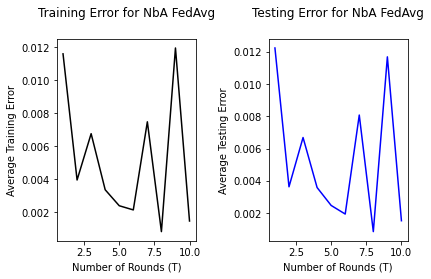

In [ ]:
#RUN FOR ERROR PLOT
print(NbAFL_training_errors)
error_plot(np.arange(1,10+1,1), NbAFL_training_errors, NbAFL_testing_errors, "Training Error for NbA FedAvg", "Testing Error for NbA FedAvg", "Number of Rounds (T)")

## 3. Reduce Communication Overhead (Volume)
Probabilistic Quantisation

Weight Subsampling

In [ ]:
def prob_quant(w):
  w_min=min(w)
  w_max=max(w)
  wq=np.zeros(len(w))
  for i in range(len(w)):
    wq[i]=np.random.choice([w_min,w_max],[(w_max-w[i])/(w_max-w_min),1-((w_max-w[i])/(w_max-w_min))])
  return wq
def device_redcommfederated_learning(alp_, w, id, n): #Conducts local training for SGD and outputs weight vector
    n_k = no_of_pts(id)
    x_cord, y_cord=fetch_coords(id)
    w_ = SGD_(w, n_k, n, x_cord, y_cord, alp_)
    delta=0.01
    eps=2
    C=5.1
    w=np.zeros(len(w_))
    for i in range(len(w)):
      w[i]=w_[i]*(1/(max([1,w_[i]/C])))
    #w_g=w + np.random.normal(0,2*math.log((1.25*delta)*(2*C*max(n_k_dev))/100),len(w)), n_k
    return prob_quant(w)

## 4. Another Attempt : Adding Random Masking
With Static Subsampling as earlier.

In [ ]:
def device_nbafederated_learning2(alp_, w, id, n): #Conducts local training for SGD and outputs weight vector
    n_k = no_of_pts(id)
    #for i in range(T):
      #n_k.append(n_k0)
    x_cord, y_cord=fetch_coords(id)
    w_ = SGD_(w, n_k, n, x_cord, y_cord, alp_)
    delta=0.01
    eps=2
    C=5.1
    w=np.zeros(len(w_))
    for i in range(len(w)):
      w[i]=w_[i]*(1/(max([1,w_[i]/C])))
    #w_g=w + np.random.normal(0,2*math.log((1.25*delta)*(2*C*max(n_k_dev))/100),len(w))
    w_g=w + np.random.normal(0,2*math.log((1.25/delta)*(C**2))/(eps**2),len(w))
    #print("w_g = ",w_g)
    s=0.25
    #np.random.seed(seed)
    ind=np.random.choice(np.arange(len(w)),size=int((1-s)*len(w)))
    mask = np.zeros(len(w))
    for i in range(len(w)):
      if i in ind:
        mask[i]=1
    #print(w_g*mask)
    return w_g*mask,n_k

In [ ]:
def federated_avg2(training_subset, w_, n_k):
    #n_ = np.sum(n_k)*(0.75)
    w_k = []
    #n_ind=np.zeros(w_n)
    for p in range(len(n_k)):
        w_k.append(n_k[p] * w_[p])
    w_1=np.transpose(w_k)
    #update n_ind with n_k
    for i in w_1:
      for j in range(len(i)):
        if i[j]!=0:
          i[j]=1
      i*=n_k
    #n_ind=[np.count_nonzero(i) for i in w_1]
    n_ind=[sum(i) for i in w_1]
    #print("n_ind=",n_ind)
    w=0
    for p in range(len(training_subset)):
        w+=(n_k[p]*w_[p])/n_ind
    return w
def SGD_nbafederated_learning2(T, K, C, w, n, alp_):
    k = np.arange(K)
    # Train for T many rounds
    seeds=[]
    w_ = np.zeros((int(C * K * T), w_n))
    n_k = np.zeros(int(C * K * T))
    z=0
    for i in range(T):
        #np.random.seed()
        #seed=np.random.randint(1)
        #seeds.append(seed)
        training_subset = np.random.randint(0, K, int(C * K))
        #np.random.rand(seed)
        for j in training_subset:
            w_[z], n_k[z] = device_nbafederated_learning2(alp_, w, j, n)
            #print(z)
            z+=1
    w_k = federated_avg2(training_subset, w_, n_k)
    return w_k

def SGD_nbafederated_learning2_plt(T, K, C, w, n, alp_):
    k = np.arange(K)
    # Train for T many rounds
    w_k=[]
    for i in range(T):
        #np.random.seed()
        w_ = []
        n_k = []
        #seed=np.random.randint(1)
        #seeds.append(seed)
        training_subset = np.random.randint(0, K, int(C * K))
        z=0
        #np.random.rand(seed)
        for j in training_subset:
            dev_res = device_nbafederated_learning2(alp_, w, j, n)
            w_.append(dev_res[0])
            n_k.append(dev_res[1])
            #print(z)
            z+=1
        w_k.append(federated_avg2(w_, n_k))
        print(i," done.")
    return w_k

In [ ]:
T = 5  # No of federated learning rounds
K = 500  # Total no of nodes
#C = 0.7  # fraction of nodes used at each iteration
C=0.25
# B = #Local batch size used at each learning iteration
# random Model
w = random.random()
b = random.random()
n = 100  # number of iteration for local training before pooling
alp_ = 0.01  # local learning rate
#m = 5
n_k = random.randint(10, 100)
x_cord1, y_cord1 = get_data(m, n_k)

time1 = time.time()
w2 = SGD_nbafederated_learning2(T, K, C, w, n, alp_)
time2 = time.time()
print("Time taken for SGD federated learning", time2 - time1,"\n w =",w2)
# Device.plot(x_cord, y_cord, w1, b1, n_k)

#time1 = time.time()
#w2, b2 = Mini_federated_learning(T, K, C, w, b, n, alp_)
#time2 = time.time()
#print("Time taken for Mini-batch SGD federated learning", time2 - time1)
# Device.plot(x_cord, y_cord, w2, b2, n_k)
# plt.show()
#dat_plot1(x_cord1, y_cord1, w2, b2, n_k, title1="NbAFedAvg on SGD")

Time taken for SGD federated learning 365.5682189464569 
 w = [1.34437206 2.34183301 3.56094899 4.03797441 5.39339701 5.25008139
 1.25352552]


In [ ]:
print("Average Training Error for NbA FedAvg w/ Random Mask on SGD = ",average_training_error(w2),"\nAverage Testing Error for NbA FedAvg w/ Random Mask on SGD = ", average_testing_error(w2))
print(" Actual weights, m = ",m)

Average Training Error for NbA FedAvg w/ Random Mask on SGD =  0.13101611851098324 
Average Testing Error for NbA FedAvg w/ Random Mask on SGD =  0.13036598162280666
 Actual weights, m =  [1, 2, 4, 3, 5, 6, 1.2]


In [ ]:
#RUN FOR ERROR PLOT
T=100
K = 500  # Total no of nodes
#C = 0.7  # fraction of nodes used at each iteration
C=0.25
# B = #Local batch size used at each learning iteration
# random Model
w = np.random.rand(7)
n = 100  # number of iteration for local training before pooling
alp_ = 0.01  # local learning rate
RM_training_errors=[]
RM_testing_errors=[]
w2 = SGD_nbafederated_learning2_plt(T, K, C, w, n, alp_)
for w_iter in w2:
  RM_training_errors.append(average_training_error(w_iter))
  RM_testing_errors.append(average_testing_error(w_iter))
#print(T1," done.")

0  done.
1  done.
2  done.
3  done.
4  done.
5  done.
6  done.
7  done.
8  done.
9  done.


In [ ]:
#RUN FOR ERROR PLOT
print(RM_training_errors)
error_plot(np.arange(1,10+1,1), RM_training_errors, RM_testing_errors, "Training Error;", "Testing Error for Random Masked, NbA FedAvg", "Number of Rounds (T)")

## 6. NbAFL with Probabilistic Quantisation

In [ ]:
def prob_quant(w):
  w_min=min(w)
  w_max=max(w)
  wq=np.zeros(len(w))
  for i in range(len(w)):
    wq[i]=float(np.random.choice([w_min,w_max],p=[((w_max-w[i])/(w_max-w_min)),(1-((w_max-w[i])/(w_max-w_min)))]))
  return wq
def device_nbafederated_learning_pq(alp_, w, id, n): #Conducts local training for SGD and outputs weight vector
    n_k = no_of_pts(id)
    #for i in range(T):
      #n_k.append(n_k0)
    x_cord, y_cord=fetch_coords(id)
    w_ = SGD_(w, n_k, n, x_cord, y_cord, alp_)
    delta=0.01
    eps=70
    C=1.01*max(m)
    w=np.zeros(len(w_))
    for i in range(len(w)):
      w[i]=w_[i]*(1/(max([1,max(w_)/C])))
    #w_g=w + np.random.normal(0,2*math.log((1.25*delta)*(2*C*max(n_k_dev))/100),len(w))
    w_g=w + np.random.normal(0,2*math.log((1.25/delta)*(C**2))/(eps**2),len(w))
    return prob_quant(w_g), n_k

In [ ]:
def SGD_nbafederated_learning_pq(T, K, C, w, n, alp_):
    k = np.arange(K)
    # Train for T many rounds
    for i in range(T):
        w_ = np.zeros((int(C * K * T), w_n))
        n_k = np.zeros(int(C * K * T))
        training_subset = np.random.randint(0, K, int(C * K))
        z=0
        for j in training_subset:
            w_[z], n_k[z] = device_nbafederated_learning_pq(alp_, w, j, n)
            #print(i,z)
            z+=1
    w_k = federated_avg(training_subset, w_, n_k)
    return w_k
def SGD_nbafederated_learning_pq_plt(T, K, C, w, n, alp_):
    k = np.arange(K)
    w_ = []
    n_k = []
    z=0
    # Train for T many rounds
    for i in range(T):
        training_subset = np.random.randint(0, K, int(C * K))
        for j in training_subset:
            dev_res = device_nbafederated_learning_pq(alp_, w, j, n)
            w.append(dev_res[0])
            n_k.append(dev_res[1])
            #print(i,z)
            z+=1
        w_k.append(federated_avg(training_subset, w_[:z], n_k[:z]))
        print(i," done.")
    return w_k

In [ ]:
T = 15  # No of federated learning rounds
K = 500  # Total no of nodes
#C = 0.7  # fraction of nodes used at each iteration
C=0.25
# B = #Local batch size used at each learning iteration
# random Model
w = random.random()
b = random.random()
n = 100  # number of iteration for local training before pooling
alp_ = 0.01  # local learning rate
#m = 5
n_k = random.randint(10, 100)
x_cord1, y_cord1 = get_data(m, n_k)

time1 = time.time()
w_pq = SGD_nbafederated_learning_pq(T, K, C, w, n, alp_)
time2 = time.time()
print("Time taken for SGD federated learning with probabilistic binarisation", time2 - time1,"\n w =",w_pq)
# Device.plot(x_cord, y_cord, w1, b1, n_k)

#time1 = time.time()
#w2, b2 = Mini_federated_learning(T, K, C, w, b, n, alp_)
#time2 = time.time()
#print("Time taken for Mini-batch SGD federated learning", time2 - time1)
# Device.plot(x_cord, y_cord, w2, b2, n_k)
# plt.show()
#dat_plot1(x_cord1, y_cord1, w2, b2, n_k, title1="NbAFedAvg on SGD")

Time taken for SGD federated learning with probabilistic binarisation 1095.7553567886353 
 w = [1.00024326 2.14072738 3.97115855 3.20425608 5.23787382 6.00072659
 1.21816426]


In [ ]:
print("Average Training Error for NbA FedAvg w/ Probabilistic Binarisation on SGD = ",average_training_error(w_pq),"\nAverage Testing Error for NbA FedAvg w/ Probabilistic Binarisation on SGD = ", average_testing_error(w_pq))
print(" Actual weights, m = ",m)

Average Training Error for NbA FedAvg w/ Probabilistic Binarisation on SGD =  0.09210373561474153 
Average Testing Error for NbA FedAvg w/ Probabilistic Binarisation on SGD =  0.09383845621004694
 Actual weights, m =  [1, 2, 4, 3, 5, 6, 1.2]


In [ ]:
#RUN FOR ERROR PLOT
T=100
K = 500  # Total no of nodes
#C = 0.7  # fraction of nodes used at each iteration
C=0.25
# B = #Local batch size used at each learning iteration
# random Model
w = np.random.rand(7)
n = 100  # number of iteration for local training before pooling
alp_ = 0.01  # local learning rate
RM_training_errors=[]
RM_testing_errors=[]
w2 = SGD_nbafederated_learning2_plt(T, K, C, w, n, alp_)
for w_iter in w2:
  RM_training_errors.append(average_training_error(w_iter))
  RM_testing_errors.append(average_testing_error(w_iter))
#print(T1," done.")

KeyboardInterrupt: ignored

## 5. Random Masking, with Dynamic Subsampling

In [ ]:
def device_nbafederated_learning3(alp_, w, id, n): #Conducts local training for SGD and outputs weight vector
    n_k = no_of_pts(id)
    #for i in range(T):
      #n_k.append(n_k0)
    x_cord, y_cord=fetch_coords(id)
    w_ = SGD_(w, n_k, n, x_cord, y_cord, alp_)
    delta=0.01
    eps=2
    C=5.1
    w=np.zeros(len(w_))
    for i in range(len(w)):
      w[i]=w_[i]*(1/(max([1,w_[i]/C])))
    #w_g=w + np.random.normal(0,2*math.log((1.25*delta)*(2*C*max(n_k_dev))/100),len(w))
    w_g=w + np.random.normal(0,2*math.log((1.25/delta)*(C**2))/(eps**2),len(w))
    #print("w_g = ",w_g)
    s=0.25
    #np.random.seed(seed)
    ind=np.random.choice(np.arange(len(w)),size=int((1-s)*len(w)))
    mask = np.zeros(len(w))
    for i in range(len(w)):
      if i in ind:
        mask[i]=1
    #print(w_g*mask)
    return w_g*mask,n_k

In [ ]:
def federated_avg3(training_subset, w_, n_k):
    #n_ = np.sum(n_k)*(0.75)
    w_k = []
    #n_ind=np.zeros(w_n)
    for p in range(len(n_k)):
        w_k.append(n_k[p] * w_[p])
    w_1=np.transpose(w_k)
    #update n_ind with n_k
    for i in w_1:
      for j in range(len(i)):
        if i[j]!=0:
          i[j]=1
      i*=n_k
    #n_ind=[np.count_nonzero(i) for i in w_1]
    n_ind=[sum(i) for i in w_1]
    print("n_ind=",n_ind) 
    w=0
    for p in range(len(n_k)):
        w+=(n_k[p]*w_[p])/n_ind
    return w
def SGD_nbafederated_learning3(T, K, C, w, n, alp_, beta):
    k = np.arange(K)
    w_ = np.zeros((int(c * K * T), w_n))
    n_k = np.zeros(int(c * K * T))
    z=0
    # Train for T many rounds
    seeds=[]
    for i in range(T):
        c=C*(1/math.exp(beta*i))
        #seed=np.random.randint(1)
        #seeds.append(seed)
        training_subset = np.random.randint(0, K, int(c * K))

        #np.random.rand(seed)
        for j in training_subset:
            w_[z], n_k[z] = device_nbafederated_learning3(alp_, w, j, n)
            #print(z)
            z+=1
    w_k = federated_avg3(training_subset, w_[:z], n_k[:z])
    return w_k

In [ ]:
T = 5  # No of federated learning rounds
K = 500  # Total no of nodes
#C = 0.7  # fraction of nodes used at each iteration
C=0.25
beta= 0.05
# B = #Local batch size used at each learning iteration
# random Model
w = random.random()
b = random.random()
n = 100  # number of iteration for local training before pooling
alp_ = 0.01  # local learning rate
#m = 5
n_k = random.randint(10, 100)
x_cord1, y_cord1 = get_data(m, n_k)

time1 = time.time()
w_dyn = SGD_nbafederated_learning3(T, K, C, w, n, alp_, beta)
time2 = time.time()
print("Time taken for SGD federated learning", time2 - time1,"\n w =",w_dyn)
# Device.plot(x_cord, y_cord, w1, b1, n_k)

#time1 = time.time()
#w2, b2 = Mini_federated_learning(T, K, C, w, b, n, alp_)
#time2 = time.time()
#print("Time taken for Mini-batch SGD federated learning", time2 - time1)
# Device.plot(x_cord, y_cord, w2, b2, n_k)
# plt.show()
#dat_plot1(x_cord1, y_cord1, w2, b2, n_k, title1="NbAFedAvg on SGD")

n_ind= [25810.0, 25540.0, 30010.0, 31974.0, 36586.0, 31664.0, 31155.0]
Time taken for SGD federated learning 333.9241933822632 
 w = [1.13882268 2.08542777 3.96749625 2.73184596 4.96160552 5.05543362
 0.61048951]


In [ ]:
print("Average Training Error for NbA FedAvg w/ Random Mask on SGD = ",average_training_error(w_dyn),"\nAverage Testing Error for NbA FedAvg w/ Random Mask on SGD = ", average_testing_error(w_dyn))
print(" Actual weights, m = ",m)

Average Training Error for NbA FedAvg w/ Random Mask on SGD =  0.7900591789217705 
Average Testing Error for NbA FedAvg w/ Random Mask on SGD =  0.9164836574369606
 Actual weights, m =  [1, 2, 4, 3, 5, 6, 1.2]


In [ ]:
def error_plot(k, sgd_err, mini_err, title1, title2, x_title):
    plt.subplot(1, 2, 1)
    plt.plot(k, sgd_err, color='Black')
    plt.xlabel(x_title)
    plt.ylabel('Average Error')
    plt.title(title1)
    plt.subplot(1, 2, 2)
    plt.plot(k, mini_err, color='Blue')
    plt.xlabel(x_title)
    plt.ylabel('Average Error')
    plt.title(title2)
    plt.show()


In [ ]:
m = 5  # slope parameter
T = 1  # No of federated learning rounds
C = 0.25 # fraction of nodes used at each iteration
w = random.random()
b = random.random()
n = 100  # number of iteration for local training before pulling
alp_ = 0.01
n_k = random.randint(10, 100)
x_cord1, y_cord1 = get_data(m, n_k)
k_=[]
sgd_error=[]
mini_error=[]
for k_n in range(50,500,50):
    n_k_dev = np.random.randint(100, 1000, k_n)
    x, y = get_data(m, sum(n_k_dev))
    i = 0
    x_cord = []
    y_cord = []
    for n0 in n_k_dev:
        x_cord.append(x[i:i + n0])
        y_cord.append(y[i:i + n0])
        i += n0
    x_cordflat = flatten(x_cord)
    y_cordflat = flatten(y_cord)
    k_.append(k_n)
    w1, b1 = SGD_federated_learning(T, k_n, C, w, b, n, alp_)
    sgd_error.append(average_error(w1, b1))
    w2, b2 = Mini_federated_learning(T, k_n, C, w, b, n, alp_)
    mini_error.append(average_error(w2,b2))
error_plot(k_,sgd_error,mini_error,title1="FedAvg on SGD",title2="FedAvg on mini-SGD",x_title="Total number of clients")

TypeError: ignored

In [ ]:
c_=[]
sgd_error=[]
mini_error=[]
for c_n in range(20,120,20):
    c_n=c_n/100
    n_k_dev = np.random.randint(100, 1000, K)
    x, y = get_data(m, sum(n_k_dev))
    i = 0
    x_cord = []
    y_cord = []
    for n0 in n_k_dev:
        x_cord.append(x[i:i + n0])
        y_cord.append(y[i:i + n0])
        i += n0
    x_cordflat = flatten(x_cord)
    y_cordflat = flatten(y_cord)
    c_.append(c_n)
    w1, b1 = SGD_federated_learning(T, K, c_n, w, b, n, alp_)
    sgd_error.append(average_error(w1, b1))
    w2, b2 = Mini_federated_learning(T, K, c_n, w, b, n, alp_)
    mini_error.append(average_error(w2,b2))
error_plot(c_,sgd_error,mini_error,title1="FedAvg on SGD",title2="FedAvg on mini-SGD",x_title="Fraction of clients used for learning")

## 6. Dynamic Subsampling

In [34]:
def device_federated_learning_dyn_samp(alp_, w, id, n): #Conducts local training for SGD and outputs weight vector
    n_k = no_of_pts(id)
    #for i in range(T):
      #n_k.append(n_k0)
    x_cord, y_cord=fetch_coords(id)
    w_ = SGD_(w, n_k, n, x_cord, y_cord, alp_)
    #delta=0.01
    #eps=2
    #C=5.1
    #w=np.zeros(len(w_))
    #for i in range(len(w)):
    #  w[i]=w_[i]*(1/(max([1,w_[i]/C])))
    #w_g=w + np.random.normal(0,2*math.log((1.25*delta)*(2*C*max(n_k_dev))/100),len(w))
    #w_g=w + np.random.normal(0,2*math.log((1.25/delta)*(C**2))/(eps**2),len(w))
    #print("w_g = ",w_g)
    #s=0.25
    #np.random.seed(seed)
    #ind=np.random.choice(np.arange(len(w)),size=int((1-s)*len(w)))
    #mask = np.zeros(len(w))
    #for i in range(len(w)):
    #  if i in ind:
    #    mask[i]=1
    #print(w_g*mask)
    return w_,n_k

In [40]:
def SGD_federated_learning_dyn_samp(T, K, C, w, n, alp_, beta):
    k = np.arange(K)
    # Train for T many rounds
    seeds=[]
    w_ = np.zeros((int(C * K * T), w_n))
    n_k = np.zeros(int(C * K * T))
    z=0
    for i in range(T):
        c=C*(1/math.exp(beta*i))
        #seed=np.random.randint(1)
        #seeds.append(seed)
        training_subset = np.random.randint(0, K, int(c * K))
        #np.random.rand(seed)
        for j in training_subset:
            w_[z], n_k[z] = device_federated_learning_dyn_samp(alp_, w, j, n)
            #print(z)
            z+=1
    w_k = federated_avg(w_[:z], n_k[:z])
    return w_k

In [ ]:
T = 3  # No of federated learning rounds
K = 500  # Total no of nodes
#C = 0.7  # fraction of nodes used at each iteration
C=0.25
beta= 0.05
# B = #Local batch size used at each learning iteration
# random Model
w = random.random()
b = random.random()
n = 100  # number of iteration for local training before pooling
alp_ = 0.01  # local learning rate
#m = 5
n_k = random.randint(10, 100)
x_cord1, y_cord1 = get_data(m, n_k)

time1 = time.time()
w_dyn = SGD_federated_learning_dyn_samp(T, K, C, w, n, alp_, beta)
time2 = time.time()
print("Time taken for SGD federated learning", time2 - time1,"\n w =",w_dyn)
# Device.plot(x_cord, y_cord, w1, b1, n_k)

#time1 = time.time()
#w2, b2 = Mini_federated_learning(T, K, C, w, b, n, alp_)
#time2 = time.time()
#print("Time taken for Mini-batch SGD federated learning", time2 - time1)
# Device.plot(x_cord, y_cord, w2, b2, n_k)
# plt.show()
#dat_plot1(x_cord1, y_cord1, w2, b2, n_k, title1="NbAFedAvg on SGD")

In [42]:
print("Average Training Error for FedAvg w/ Dyn Sampling on SGD = ",average_training_error(w_dyn),"\nAverage Testing Error for FedAvg w/ Dyn Sampling on SGD = ", average_testing_error(w_dyn))
print(" Actual weights, m = ",m)

Average Training Error for FedAvg w/ Dyn Sampling on SGD =  4.708314660096173e-18 
Average Testing Error for FedAvg w/ Dyn Sampling on SGD =  5.280313205126087e-18
 Actual weights, m =  [1, 2, 4, 3, 5, 6, 1.2]


## 1.* Adaptive Sampling

In [43]:
def device_federated_learning_adap_samp(alp_, w, id, n): #Conducts local training for SGD and outputs weight vector
    n_k = no_of_pts(id)
    #for i in range(T):
      #n_k.append(n_k0)
    x_cord, y_cord=fetch_coords(id)
    w_ = SGD_(w, n_k, n, x_cord, y_cord, alp_)
    #delta=0.01
    #eps=2
    #C=5.1
    #w=np.zeros(len(w_))
    #for i in range(len(w)):
    #  w[i]=w_[i]*(1/(max([1,w_[i]/C])))
    #w_g=w + np.random.normal(0,2*math.log((1.25*delta)*(2*C*max(n_k_dev))/100),len(w))
    #w_g=w + np.random.normal(0,2*math.log((1.25/delta)*(C**2))/(eps**2),len(w))
    #print("w_g = ",w_g)
    #s=0.25
    #np.random.seed(seed)
    #ind=np.random.choice(np.arange(len(w)),size=int((1-s)*len(w)))
    #mask = np.zeros(len(w))
    #for i in range(len(w)):
    #  if i in ind:
    #    mask[i]=1
    #print(w_g*mask)
    return w_,n_k

In [48]:
def SGD_federated_learning_adap_samp(T, K, C, w, n, alp_, beta):
    k = np.arange(K)
    beta0=beta
    error=[]
    error_t=0
    w_ = np.zeros((int(C * K * T), w_n))
    n_k = np.zeros(int(C * K * T))
    z=0
    # Train for T many rounds
    for i in range(T):
        c=C*(1/math.exp(beta0*i))
        #seed=np.random.randint(1)
        #seeds.append(seed)
        training_subset = np.random.randint(0, K, int(c * K))
        #np.random.rand(seed)
        for j in training_subset:
            w_[z], n_k[z] = device_federated_learning_adap_samp(alp_, w, j, n)
            #print(z)
            z+=1
        w_k = federated_avg(w_[:z], n_k[:z])
        error.append(average_testing_error(w_k))
        if i>0:
          if error[i]>error[i-1]:
            beta0*=((error[i]/error[i-1])*(i/i+1))
            error_t=error[i-1]
        #if beta0!=beta:
        #  if error[i]<=error_t:
        #    beta0=beta
    #w_k = federated_avg(training_subset, w_, n_k)
    return w_k

In [49]:
T = 3  # No of federated learning rounds
K = 500  # Total no of nodes
#C = 0.7  # fraction of nodes used at each iteration
C=0.25
beta= 0.05
# B = #Local batch size used at each learning iteration
# random Model
w = random.random()
b = random.random()
n = 100  # number of iteration for local training before pooling
alp_ = 0.01  # local learning rate
#m = 5
n_k = random.randint(10, 100)
x_cord1, y_cord1 = get_data(m, n_k)

time1 = time.time()
w_dyn = SGD_federated_learning_adap_samp(T, K, C, w, n, alp_, beta)
time2 = time.time()
print("Time taken for SGD federated learning", time2 - time1,"\n w =",w_dyn)
# Device.plot(x_cord, y_cord, w1, b1, n_k)

#time1 = time.time()
#w2, b2 = Mini_federated_learning(T, K, C, w, b, n, alp_)
#time2 = time.time()
#print("Time taken for Mini-batch SGD federated learning", time2 - time1)
# Device.plot(x_cord, y_cord, w2, b2, n_k)
# plt.show()
#dat_plot1(x_cord1, y_cord1, w2, b2, n_k, title1="NbAFedAvg on SGD")

KeyboardInterrupt: ignored

In [ ]:
print("Average Training Error for FedAvg w/ Adaptive Sampling on SGD = ",average_training_error(w_dyn),"\nAverage Testing Error for FedAvg w/ Adaptive Sampling on SGD = ", average_testing_error(w_dyn))
print(" Actual weights, m = ",m)

Average Training Error for FedAvg w/ Adaptive Sampling on SGD =  4.96006450863426e-16 
Average Testing Error for FedAvg w/ Adaptive Sampling on SGD =  4.5197962733548135e-16
 Actual weights, m =  [1, 2, 4, 3, 5, 6, 1.2]


## 1.1* Adaptive Sampling with NbA

In [ ]:
def device_nbafederated_learning_adap_samp(alp_, w, id, n): #Conducts local training for SGD and outputs weight vector
    n_k = no_of_pts(id)
    #for i in range(T):
      #n_k.append(n_k0)
    x_cord, y_cord=fetch_coords(id)
    w_ = SGD_(w, n_k, n, x_cord, y_cord, alp_)
    #delta=0.01
    #eps=2
    #C=5.1
    #w=np.zeros(len(w_))
    #for i in range(len(w)):
    #  w[i]=w_[i]*(1/(max([1,w_[i]/C])))
    #w_g=w + np.random.normal(0,2*math.log((1.25*delta)*(2*C*max(n_k_dev))/100),len(w))
    #w_g=w + np.random.normal(0,2*math.log((1.25/delta)*(C**2))/(eps**2),len(w))
    #print("w_g = ",w_g)
    #s=0.25
    #np.random.seed(seed)
    #ind=np.random.choice(np.arange(len(w)),size=int((1-s)*len(w)))
    #mask = np.zeros(len(w))
    #for i in range(len(w)):
    #  if i in ind:
    #    mask[i]=1
    #print(w_g*mask)
    return w_,n_k

In [ ]:
def SGD_federated_learning_ada_samp(T, K, C, w, n, alp_, beta):
    k = np.arange(K)
    beta0=beta
    error=[]
    error_t=0
    # Train for T many rounds
    for i in range(T):
        c=C*(1/math.exp(beta0*i))
        w_ = np.zeros((int(c * K), w_n))
        n_k = np.zeros(int(c * K))
        #seed=np.random.randint(1)
        #seeds.append(seed)
        training_subset = np.random.randint(0, K, int(c * K))
        z=0
        #np.random.rand(seed)
        for j in training_subset:
            w_[z], n_k[z] = device_nbafederated_learning_adap_samp(alp_, w, j, n)
            #print(z)
            z+=1
        w_k = federated_avg(training_subset, w_, n_k)
        error.append(average_testing_error(w_k))
        #if i>0:
        #  if error[i]>error[i-1]:
        #    beta0*=(error[i-1]/error[i])*2
        #    error_t=error[i-1]
        #if beta0!=beta:
        #  if error[i]<=error_t:
        #    beta0=beta
    #w_k = federated_avg(training_subset, w_, n_k)
    return w_k

In [ ]:
T = 5  # No of federated learning rounds
K = 500  # Total no of nodes
#C = 0.7  # fraction of nodes used at each iteration
C=0.25
beta= 0.05
# B = #Local batch size used at each learning iteration
# random Model
w = random.random()
b = random.random()
n = 100  # number of iteration for local training before pooling
alp_ = 0.01  # local learning rate
#m = 5
n_k = random.randint(10, 100)
x_cord1, y_cord1 = get_data(m, n_k)

time1 = time.time()
w_dyn = SGD_federated_learning_dyn_samp(T, K, C, w, n, alp_, beta)
time2 = time.time()
print("Time taken for SGD federated learning", time2 - time1,"\n w =",w_dyn)
# Device.plot(x_cord, y_cord, w1, b1, n_k)

#time1 = time.time()
#w2, b2 = Mini_federated_learning(T, K, C, w, b, n, alp_)
#time2 = time.time()
#print("Time taken for Mini-batch SGD federated learning", time2 - time1)
# Device.plot(x_cord, y_cord, w2, b2, n_k)
# plt.show()
#dat_plot1(x_cord1, y_cord1, w2, b2, n_k, title1="NbAFedAvg on SGD")

Time taken for SGD federated learning 333.95433926582336 
 w = [1.0000001  1.99999997 4.00000007 3.00000008 4.99999994 5.99999987
 1.19999998]


In [ ]:
print("Average Training Error for FedAvg w/ Dyn Sampling on SGD = ",average_training_error(w_dyn),"\nAverage Testing Error for FedAvg w/ Dyn Sampling on SGD = ", average_testing_error(w_dyn))
print(" Actual weights, m = ",m)

Average Training Error for FedAvg w/ Dyn Sampling on SGD =  3.7190119635908776e-15 
Average Testing Error for FedAvg w/ Dyn Sampling on SGD =  3.060815956838882e-15
 Actual weights, m =  [1, 2, 4, 3, 5, 6, 1.2]
